In [1]:
import numpy as np
import pandas as pd
import warnings
from tqdm import tqdm
import random
import math
import matplotlib.pyplot as plt
import seaborn as sns

tqdm.pandas()
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv("./max_data/max_dataset.csv")
data = data.fillna("Nil")
data.replace("0", "Nil", inplace=True)
data.replace("Nil", 0, inplace=True)
data.replace("Negative", 0, inplace=True)
data.replace("Normal", 0, inplace=True)
data.replace("Absent", 0, inplace=True)
data.replace("Yes", True, inplace=True)
data.replace("No", False, inplace=True)
data.replace("yes", True, inplace=True)
data.replace("no", False, inplace=True)
data.replace("True", True, inplace=True)
data.replace("False", False, inplace=True)
data = data.select_dtypes(include=[int, float, bool, object])
data = data.drop(columns=[data.columns[0], data.columns[1]])
data["PDOB.dob"] = data["PDOB.dob"].apply(lambda x: int(x.split("-")[-1]))
data

,PDOB.dob,PGDR.gender,PCHC.chiefcomplains,DAAA.doyouhaveanyallergies?,DAAD.drugallergies,DAAF.fooditemallergies,DAAS.skinallergies,DAAR.respiratoryallergies,DAAO.anyotherallergies,"HLSO.doyoucurrentlysmokeanytobaccoproductsdaily,suchascigarettes,cigarsorpipes?",...,LSTP.trophozoite,LAUB.uibc,LBRU.urea,LBRA.uricacid,LUSF.urinesugarfasting,LUSP.urinesugarpp,LUUB.urobilinogen,LABT.vitaminb12,LBLV.vldlcholesterol,LEEK.whitebloodcell
0,1963,Male,0,True,0,0,Due to summer,0,0,False,...,0,0.0,12.4,5.0,0,0,0,0,15.2,1-2
1,1975,Female,0,False,0,0,0,0,0,False,...,0,0.0,0,0.0,0,0,0,0,0.0,1-2
2,1969,Male,0,False,0,0,0,0,0,False,...,0,0.0,17.4,6.1,0,0,0,0,19.2,0-1
3,1963,Male,Asthma,True,0,0,0,Dust,0,False,...,0,0.0,28.7,5.0,0,0,0,0,16.0,2-4
4,1974,Male,0,False,0,0,0,0,0,False,...,0,0.0,17.0,7.3,0,0,0,0,56.4,0-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2687,1975,Female,0,False,0,0,0,0,0,False,...,0,0.0,21.0,4.2,0,0,0,0,31.4,2-3
2688,1962,Male,0,False,0,0,0,0,0,True,...,0,0.0,22.6,6.3,0,0,0,0,14.4,2-4
2689,1972,Male,0,False,0,0,0,0,0,True,...,0,0.0,31.3,7.6,0,0,0,169,34.4,0-1
2690,1967,Male,0,False,0,0,0,0,0,False,...,0,0.0,24.1,7.5,0,0,0,0,33.2,1-2


In [3]:
desc = pd.read_excel("./max_data/003_data-description-OMOP_coded-31Aug23--PPRK.xlsx").iloc[2:, :]
desc

,field_information,php_code_header,variable_names,codes,person,observation,condition_occurrence,procedure_occurrence,drug_exposure,device_exposure,measurements,specimen,fact_relationship,visit_occurrence,observation_period
2,Personal,PDOB.dob,DOB,PDOB,1,0,0,0,0,0,0,0,0,0,0
3,Personal,PGDR.gender,Gender,PGDR,1,0,0,0,0,0,0,0,0,0,0
4,Personal,PCHC.chiefcomplains,Chief Complains,PCHC,0,0,1,0,0,0,0,0,0,0,0
5,Allergies,DAAA.doyouhaveanyallergies?,Do you have any Allergies?,DAAA,0,1,1,0,0,0,0,0,0,0,0
6,Allergies,DAAD.drugallergies,Drug Allergies:,DAAD,0,1,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
626,Blood Test Report,LUSP.urinesugarpp,Strength,LUSP,0,0,0,0,0,0,1,1,1,0,0
627,Blood Test Report,LUUB.urobilinogen,Strength,LUUB,0,0,0,0,0,0,1,1,1,0,0
628,Blood Test Report,LABT.vitaminb12,Strength,LABT,0,0,0,0,0,0,1,1,1,0,0
629,Blood Test Report,LBLV.vldlcholesterol,Strength,LBLV,0,0,0,0,0,0,1,1,1,0,0


In [4]:
desc["lifestyle"] = desc["field_information"].apply(lambda x: x in ["Alcohol History", "Physical Activity", "Social and Personal History ", "Allergies ", "Travel History", "Personal", "Food habits", "Sleep"])
desc["medical"] = desc["field_information"].apply(lambda x: x in ["Current Medications", "Past Medical History", "FAMILY HISTORY: Father", "Siblings/Others", "Grand Mother", "Grand Father", "Aunty", "Mother", "Uncle", "Investigation Comments/ Reports ", "General Examination", "Past Surgical History", "Systemic Examination", "Allergies ", "Anthropometric Data"])
desc["measure"] = desc["field_information"].apply(lambda x: x in ["Blood Test Report ", "Current Medications", "Past Medical History", "Anthropometric Data", "Vitals", "Radiographs/ Spirometry", "Personal"])
desc["family"] = desc["field_information"].apply(lambda x: x in ["FAMILY HISTORY: Father", "Siblings/Others", "Grand Mother", "Grand Father", "Aunty", "Mother", "Uncle"])
desc["cat"] = desc.apply(lambda x: "Lifestyle" if x["lifestyle"] else "Medical" if x["medical"] else "Measure" if x["measure"] else "Nothing", axis=1)
desc["type"] = desc.apply(lambda x: "Medical Data" if x["field_information"] in ["Blood Test Report", "Vitals", "Anthropometric Data", "Radiographs/ Spirometry", "Investigation Comments/ Reports ", "General Examination", "Systemic Examination"] else "Survey Response", axis=1)

In [5]:
print(desc.loc[:, ["type", "cat", "field_information"]].value_counts().reset_index().sort_values(by=["type", "cat", "count"], ascending=False))

               type        cat                 field_information  count
1   Survey Response    Medical               Current Medications     80
2   Survey Response    Medical              Past Medical History     56
3   Survey Response    Medical                             Uncle     33
4   Survey Response    Medical                   Siblings/Others     33
5   Survey Response    Medical                            Mother     33
6   Survey Response    Medical                      Grand Mother     33
7   Survey Response    Medical                      Grand Father     33
8   Survey Response    Medical            FAMILY HISTORY: Father     33
9   Survey Response    Medical                             Aunty     33
15  Survey Response    Medical             Past Surgical History      9
0   Survey Response    Measure                Blood Test Report     136
11  Survey Response  Lifestyle      Social and Personal History      15
12  Survey Response  Lifestyle                 Physical Activity

In [6]:
self_rows = desc[(desc["field_information"] == "Past Medical History") & (~desc["php_code_header"].str.contains("yearofend|duration|HPWO|HPWS|HPXS|HPXO|HPPO.others2|HPPS"))]["php_code_header"]
father_rows = desc[(desc["family"] == True) & (desc["field_information"] == "FAMILY HISTORY: Father") & (~desc["php_code_header"].str.contains("yearofend|duration"))]["php_code_header"]
mother_rows = desc[(desc["family"] == True) & (desc["field_information"] == "Mother") & (~desc["php_code_header"].str.contains("yearofend|duration"))]["php_code_header"]
grandfather_rows = desc[(desc["family"] == True) & (desc["field_information"] == "Grand Father") & (~desc["php_code_header"].str.contains("yearofend|duration"))]["php_code_header"]
grandmother_rows = desc[(desc["family"] == True) & (desc["field_information"] == "Grand Mother") & (~desc["php_code_header"].str.contains("yearofend|duration"))]["php_code_header"]
self = data.loc[:, self_rows]
father = data.loc[:, father_rows]
mother = data.loc[:, mother_rows]
grandfather = data.loc[:, grandfather_rows]
grandmother = data.loc[:, grandmother_rows]

In [8]:
def support_count(df, r):
    return ((df.iloc[r] != 0) & (df.iloc[r] != 0.0) & (df.iloc[r] != False)).sum()

In [9]:
def support_columns(df, r):
    return df[df.loc[r, df.loc[r].apply(lambda x: x != 0 and x != 0.0 and x != False)].index].columns

In [10]:
def support(df, r):
    return df[df.loc[r, df.loc[r].apply(lambda x: x != 0 and x != 0.0 and x != False)].index]

In [11]:
def support_values(df, r):
    return df[df.loc[r, df.loc[r].apply(lambda x: x != 0 and x != 0.0 and x != False)].index].iloc[r]

In [12]:
def support_count_c(df, c):
    return ((df.loc[:, c] != 0) & (df.loc[:, c] != 0.0) & (df.loc[:, c] != False)).sum()

In [13]:
def union_support_count(df, r1, r2):
    
    columns1 = support_columns(df, r1)
    columns2 = support_columns(df, r2)
    
    return len(list(set(columns1) | set(columns2)))

In [14]:
def union_support_columns(df, r1, r2):
    
    columns1 = support_columns(df, r1)
    columns2 = support_columns(df, r2)
    
    return list(set(columns1) | set(columns2))

In [15]:
# Sim(ri1, ri2) as defined by the paper
def similar(ri1, ri2):
    
    if type(ri1) is np.int64 or type(ri1) is int or type(ri1) is np.float64:
        ri1 = float(ri1)
    if type(ri2) is np.int64 or type(ri2) is int or type(ri2) is np.float64:
        ri2 = float(ri2)
    
    if type(ri1) != type(ri2):
        return 0
    elif (type(ri1) is np.float64 and type(ri2) is np.float64) or (type(ri1) is float and type(ri2) is float):
        # return 1 if math.isclose(ri1, ri2, rel_tol=1e-9) else 0
        return 1 if abs(abs(ri2) - abs(ri1)) <= (0.1 * ri1) else 0
    elif (type(ri1) is bool and type(ri2) is bool) or (type(ri1) is np.bool_ and type(ri2) is np.bool_):
        return 1 if ri1 == ri2 else 0
    elif type(ri1) is str and type(ri2) is str:
        return 1 if ri1 == ri2 else 0
    else:
        print(f"Uncaught, {type(ri1)}, {type(ri2)}")
        return 0

In [16]:
# Sim(r1, r2) as defined by the paper
def compute_similarity(df, r1, r2):
    
    similarity = pd.Series(union_support_columns(df, r1, r2)).apply(lambda column: similar(df.loc[r1, column], df.loc[r2, column])).sum()
    sim_score = similarity/union_support_count(df, r1, r2) if union_support_count(df, r1, r2) != 0 else 0
    return sim_score

In [ ]:
# For the adversary's information, Aux(r). This randomly selects the columns that they know about
# We can consider a different method as well, based on some information measure, for eg some entropy measure or the number of rows that each column has a valid value for
def auxillary_columns(df, r, count):
    
    # supports = support_columns(df, r).to_series().apply(lambda c: support_count_c(df, c))
    # aux = list(supports.sort_values().iloc[:min(count, len(supports))].index)
    
    # aux = random.sample(list(support_columns(df, r)), min(count, support_count(df, r)))
    
    # aux = random.sample(list(set(list(df.columns[:66])).intersection(set(support_columns(df, r)))), count)
    
    # aux = random.sample(list(set(list(df.columns[66:493])).intersection(set(support_columns(df, r)))), count)
    
    aux = random.sample(list(set(list(df.columns[362:])).intersection(set(support_columns(df, r)))), count)
    
    return aux

In [18]:
# Aux(r) as defined by the paper
def auxillary(df, r, count):
    
    aux = df.loc[r, auxillary_columns(df, r, count)]
    return aux

In [19]:
# Score(aux, r') as defined by the paper
def score(df, aux, r0):
    
    scores = pd.Series(aux.index).apply(lambda column: similar(aux.loc[column], df.loc[r0, column]))
    return scores.sum()/len(aux.index) if len(aux.index) != 0 else 0


In [20]:
# Robust Score(aux, r') as defined by the paper
def score_robust(df, aux, r0):
    
    scores = pd.Series(aux.index).apply(lambda column: (similar(aux.loc[column], df.loc[r0, column]))/max(1, math.log(support_count_c(df, column))))
    return scores.sum()


In [21]:
# Best guess as defined by the paper
def best_guess(candidates, eccentricity):
    sorted_candidates = candidates.sort_values(ascending=False)
    heuristic = (sorted_candidates.index[0] - sorted_candidates.index[1])/candidates.std()
    return sorted_candidates.index[0] if heuristic >= eccentricity else None

In [22]:
# Matching criterion as defined by the paper
def match(df, aux, alpha):
    
    candidates = pd.Series(df.index).apply(lambda row: score(df, aux, row))
    candidates = candidates[candidates >= alpha]
    if candidates.empty:
        return pd.Series({"-1": 0})
    return candidates

In [23]:
# Robust matching criterion as defined by the paper
def match_robust(df, aux, alpha):
    
    candidates = pd.Series(df.index).apply(lambda row: score_robust(df, aux, row))
    if candidates.empty:
        return pd.Series({"-1": 0})
    elif candidates.shape[0] > 1:
        return best_guess(candidates, 1.5)
    return candidates

In [24]:
# Apply Score(aux, r') as defined by the paper
def scoreboard(df, count):
    
    aux_series = pd.Series(df.index).apply(lambda r1: auxillary(df, r1, count))
    scores = pd.DataFrame(index=df.index, columns=df.index)
    matches = []
    
    for r1 in tqdm(list(df.index)):
        scores.loc[r1, :] = pd.Series(df.index).apply(lambda r2: score(df, aux_series.loc[r1, ~aux_series.loc[r1].isna()], r2))
        matches.append(len(match(df, aux_series.loc[r1, ~aux_series.loc[r1].isna()], 0.75)))
    
    return scores, matches

In [25]:
# Apply robust Score(aux, r') as defined by the paper
def scoreboard_robust(df, count):
    
    aux_series = pd.Series(df.index).apply(lambda r1: auxillary(df, r1, count))
    scores = pd.DataFrame(index=df.index, columns=df.index)
    
    for r1 in tqdm(list(df.index)):
        scores.loc[r1, :] = pd.Series(df.index).apply(lambda r2: score_robust(df, aux_series.loc[r1, ~aux_series.loc[r1].isna()], r2))
            
    return scores

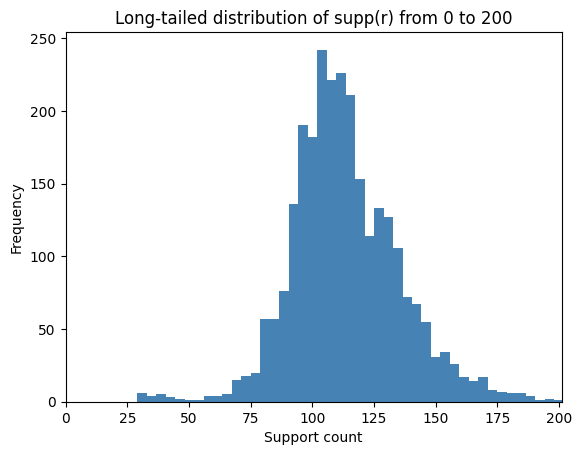

In [26]:
support_counts = pd.Series(data.index).apply(lambda x: support_count(data, x))
support_counts.plot(kind="hist", bins=50, color="steelblue", title="Long-tailed distribution of supp(r) from 0 to 200", xlim=(0, 201), xlabel="Support count", ylabel="Frequency")
plt.show()

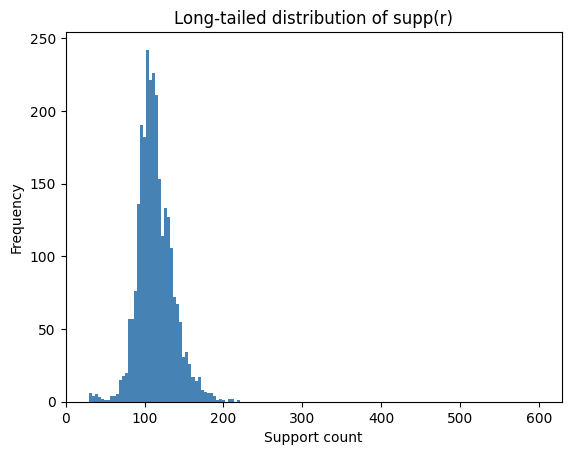

In [27]:
support_counts.plot(kind="hist", bins=50, color="steelblue", title="Long-tailed distribution of supp(r)", xlim=(0, len(data.columns)), xlabel="Support count", ylabel="Frequency")
plt.show()

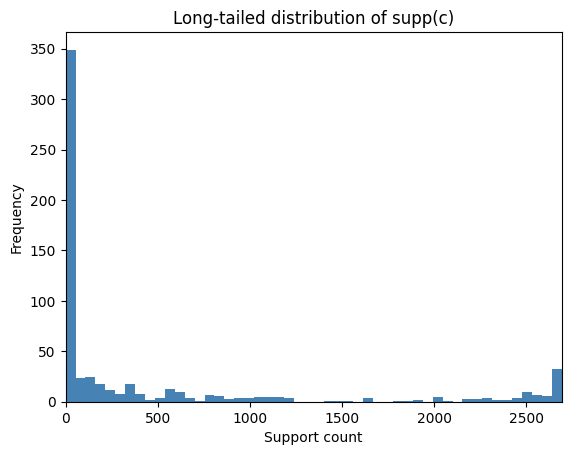

In [28]:
support_counts = pd.Series(data.columns).apply(lambda x: support_count_c(data, x))
support_counts.plot(kind="hist", bins=50, color="steelblue", title="Long-tailed distribution of supp(c)", xlim=(0, len(data)), xlabel="Support count", ylabel="Frequency")
plt.show()

In [29]:
df3 = data.loc[:, [col for col in data.columns]]
df3

,PDOB.dob,PGDR.gender,PCHC.chiefcomplains,DAAA.doyouhaveanyallergies?,DAAD.drugallergies,DAAF.fooditemallergies,DAAS.skinallergies,DAAR.respiratoryallergies,DAAO.anyotherallergies,"HLSO.doyoucurrentlysmokeanytobaccoproductsdaily,suchascigarettes,cigarsorpipes?",...,LSTP.trophozoite,LAUB.uibc,LBRU.urea,LBRA.uricacid,LUSF.urinesugarfasting,LUSP.urinesugarpp,LUUB.urobilinogen,LABT.vitaminb12,LBLV.vldlcholesterol,LEEK.whitebloodcell
0,1963,Male,0,True,0,0,Due to summer,0,0,False,...,0,0.0,12.4,5.0,0,0,0,0,15.2,1-2
1,1975,Female,0,False,0,0,0,0,0,False,...,0,0.0,0,0.0,0,0,0,0,0.0,1-2
2,1969,Male,0,False,0,0,0,0,0,False,...,0,0.0,17.4,6.1,0,0,0,0,19.2,0-1
3,1963,Male,Asthma,True,0,0,0,Dust,0,False,...,0,0.0,28.7,5.0,0,0,0,0,16.0,2-4
4,1974,Male,0,False,0,0,0,0,0,False,...,0,0.0,17.0,7.3,0,0,0,0,56.4,0-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2687,1975,Female,0,False,0,0,0,0,0,False,...,0,0.0,21.0,4.2,0,0,0,0,31.4,2-3
2688,1962,Male,0,False,0,0,0,0,0,True,...,0,0.0,22.6,6.3,0,0,0,0,14.4,2-4
2689,1972,Male,0,False,0,0,0,0,0,True,...,0,0.0,31.3,7.6,0,0,0,169,34.4,0-1
2690,1967,Male,0,False,0,0,0,0,0,False,...,0,0.0,24.1,7.5,0,0,0,0,33.2,1-2


In [30]:
shares = data.columns.to_series().apply(lambda x: int((list(data.loc[:, x].value_counts())[0])/len(data)*100))
roundshares = shares.apply(lambda x: True if x > 66 else False)
roundshares.value_counts()

True     521
False    108
Name: count, dtype: int64

In [31]:
# df4 = data.progress_apply(lambda col: col.apply(lambda x: x != col.mode()[0]) if roundshares.get(col.name, False) else col)
# df4.to_csv("./results/df4.csv", index=False)
df4 = pd.read_csv("./results/df4.csv")
df4

,PDOB.dob,PGDR.gender,PCHC.chiefcomplains,DAAA.doyouhaveanyallergies?,DAAD.drugallergies,DAAF.fooditemallergies,DAAS.skinallergies,DAAR.respiratoryallergies,DAAO.anyotherallergies,"HLSO.doyoucurrentlysmokeanytobaccoproductsdaily,suchascigarettes,cigarsorpipes?",...,LSTP.trophozoite,LAUB.uibc,LBRU.urea,LBRA.uricacid,LUSF.urinesugarfasting,LUSP.urinesugarpp,LUUB.urobilinogen,LABT.vitaminb12,LBLV.vldlcholesterol,LEEK.whitebloodcell
0,30-Aug-1963,False,0,True,False,False,True,False,False,False,...,False,False,12.4,5.0,False,False,False,False,15.2,1-2
1,1-Jan-1975,True,0,False,False,False,False,False,False,False,...,False,False,0.0,0.0,False,False,False,False,0.0,1-2
2,8-Feb-1969,False,0,False,False,False,False,False,False,False,...,False,False,17.4,6.1,False,False,False,False,19.2,0-1
3,7-Aug-1963,False,Asthma,True,False,False,False,True,False,False,...,False,False,28.7,5.0,False,False,False,False,16.0,2-4
4,1-Feb-1974,False,0,False,False,False,False,False,False,False,...,False,False,17.0,7.3,False,False,False,False,56.4,0-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2687,7-May-1975,True,0,False,False,False,False,False,False,False,...,False,False,21.0,4.2,False,False,False,False,31.4,2-3
2688,6-Feb-1962,False,0,False,False,False,False,False,False,True,...,False,False,22.6,6.3,False,False,False,False,14.4,2-4
2689,31-Oct-1972,False,0,False,False,False,False,False,False,True,...,False,False,31.3,7.6,False,False,False,True,34.4,0-1
2690,25-Jul-1967,False,0,False,False,False,False,False,False,False,...,False,False,24.1,7.5,False,False,False,False,33.2,1-2


In [34]:
similar(df3.iloc[0, 1], df3.iloc[3, 1])

1

In [35]:
compute_similarity(df3, 0, 3)

0.4017094017094017

In [36]:
print(auxillary_columns(df3, 1, 3))

['LBDV.averageglucosevalueforthelast3months', 'ENWT.weight(kg)', 'LBDA.glycosylatedhaemoglobin(hba1c)ifcc']


In [38]:
# nn = pd.Series(df3.index).iloc[:20].progress_apply(lambda x: max([compute_similarity(df3, x, i) for i in df3.index if i != x]))
# nn.to_csv("./nearestneighbours.csv")
nn = pd.read_csv("./results/nearestneighbours.csv", index_col=0)
nn2 = pd.read_csv("./results/nearestneighbours_presence_r3.csv", index_col=0)
nn.head()

,0
0,0.263158
1,0.224490
2,0.256410
3,0.258621
4,0.256637


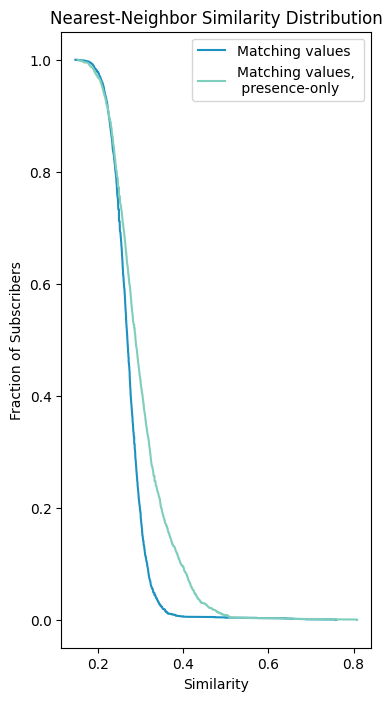

In [39]:
sorted_nn = nn.reset_index().sort_values(by="0", ascending=False)
fractions = np.arange(1, len(sorted_nn) + 1) / len(sorted_nn)

sorted_nn2 = nn2.reset_index().sort_values(by="0", ascending=False)
fractions2 = np.arange(1, len(sorted_nn2) + 1) / len(sorted_nn2)

plt.figure(figsize=(4, 8))
plt.plot(sorted_nn["0"].values, fractions, marker='', label='Matching values', color="#1d91c0")
plt.plot(sorted_nn2["0"].values, fractions, marker='', label='Matching values, \n presence-only', color="#7fcdbb")
plt.xlabel("Similarity")
plt.ylabel("Fraction of Subscribers")
plt.title("Nearest-Neighbor Similarity Distribution")
plt.legend(fontsize=10)
plt.show()

In [40]:
auxillary(df3, 54, 4)

LHCC.mch                         27.2
LHCA.basophils                    0.7
LHCP.neutrophils                 61.8
LHCI.totalleucocytecount(tlc)     5.3
Name: 54, dtype: object

In [41]:
score(df3, auxillary(df3, 54, 4), 0)

0.75

In [42]:
match(df3, auxillary(df3, 3, 10), 0.9)

3    1.0
dtype: float64

In [40]:
def load_results(filepath):
    results = ["" for _ in range(18)]
    line_values = [[0 for _ in range(1, 18)] for _ in range(4)]
    
    for i in tqdm(range(1, 17)):
        results[i] = pd.read_csv(f"{filepath}/results_{i}features.csv")

    for i in tqdm(range(1, 17)):
        
        df = results[i]
        line_values[0][i] = sum(df.iloc[j, j] == df.iloc[j].max() for j in range(len(df)))
        line_values[1][i] = sum(df.iloc[j, j] == df.iloc[j].max() and (df.iloc[j, :] == 1.0).sum() <= 5 for j in range(len(df)))
        line_values[2][i] = sum(df.iloc[j, j] == df.iloc[j].max() and (df.iloc[j, :] >= 0.9).sum() <= 5 for j in range(len(df)))
        line_values[3][i] = sum(df.iloc[j, j] == df.iloc[j].max() and (df.iloc[j, :] == 1.0).sum() == 1 for j in range(len(df)))

    line_values = [[(x/len(df3))*100 for x in line_values[i]] for i in range(4)]
    
    return results, line_values

In [ ]:
def plot_results(line_values, title_string):
    
    x = np.arange(len(line_values[0])-1)
    width = 0.2

    fig, ax = plt.subplots(figsize=(10, 6))
    bars1 = ax.bar(x - width*1.5, line_values[0][1:], width, label='Correctly identified', color='#edf8b1')
    bars2 = ax.bar(x - width*0.5, line_values[1][1:], width, label='Correctly identified, <=5 indistinguishable candidates', color='#7fcdbb')
    bars3 = ax.bar(x + width*0.5, line_values[2][1:], width, label='Correctly identified, <=5 90% similar candidates', color='#1d91c0')
    bars4 = ax.bar(x + width*1.5, line_values[3][1:], width, label='Correctly identified, no indistinguishable candidate', color='#0c2c84')

    ax.set_xlabel('Number of features known to adversary', fontsize=8)
    ax.set_ylabel('Percent of individuals succesfully deanonymized', fontsize=8)
    ax.set_title(f'Percent success of de-anonymization; {title_string}', fontsize=10)
    ax.set_xticks(x)
    ax.set_xticklabels([str(x) for x in range(1, 17)])
    ax.legend(fontsize=8, loc="lower right")

    plt.tight_layout()
    plt.show()

100%|██████████| 16/16 [00:20<00:00,  1.26s/it]


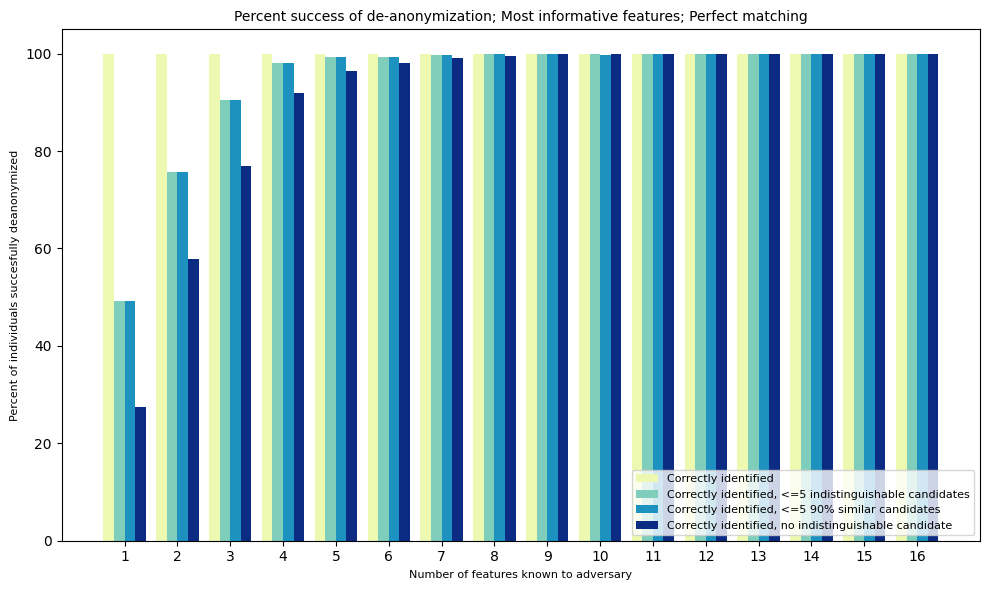

In [ ]:
# Most informative, perfect information
r_mostinfo_perfect_regular, lv_mostinfo_perfect_regular = load_results("./results/r_mostinfo_perfect_regular")
plot_results(lv_mostinfo_perfect_regular, "Most informative features; Perfect matching")

100%|██████████| 16/16 [00:20<00:00,  1.29s/it]


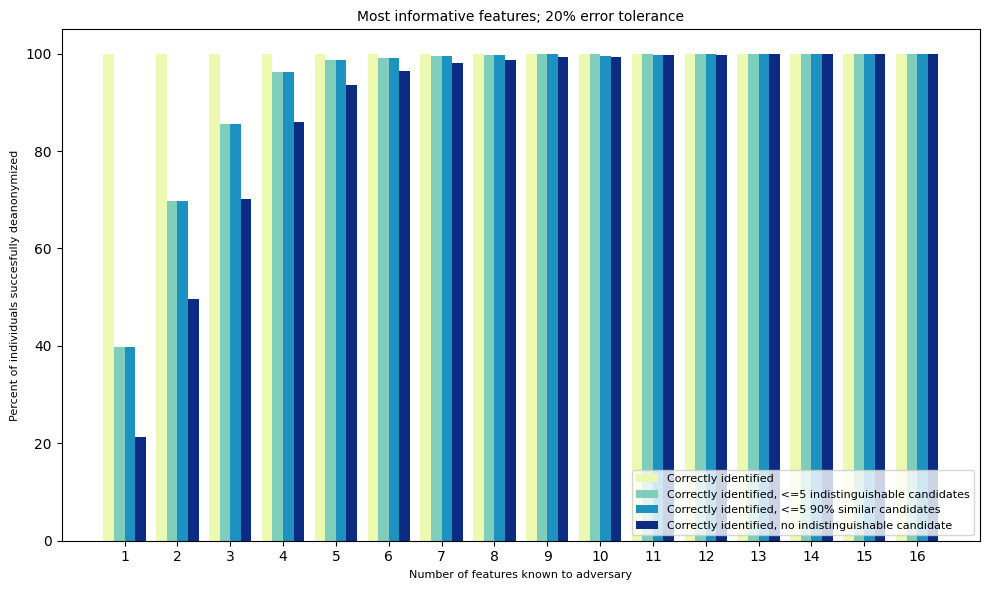

In [ ]:
# Most informative, 20% error tolerance
r_mostinfo_twenty_regular, lv_mostinfo_twenty_regular = load_results("./results/r_mostinfo_twenty_regular")
plot_results(lv_mostinfo_twenty_regular, "Most informative features; 20% error tolerance")

100%|██████████| 16/16 [00:20<00:00,  1.25s/it]


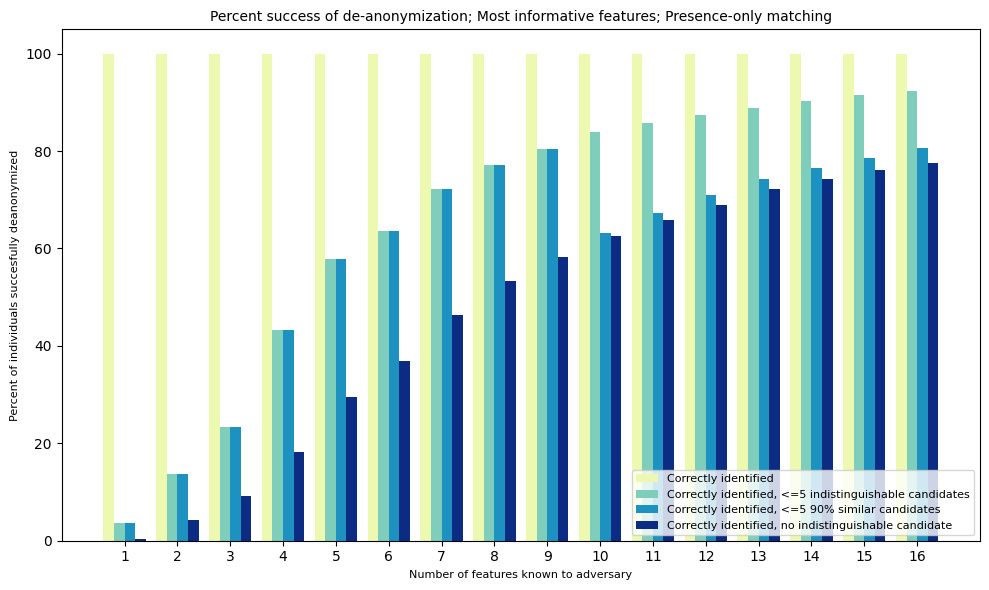

In [47]:
# Most informative, presence only
r_mostinfo_presence_regular, lv_mostinfo_presence_regular = load_results("./results/r_mostinfo_presence_regular")
plot_results(lv_mostinfo_presence_regular, "Most informative features; Presence-only matching")

100%|██████████| 16/16 [00:21<00:00,  1.33s/it]


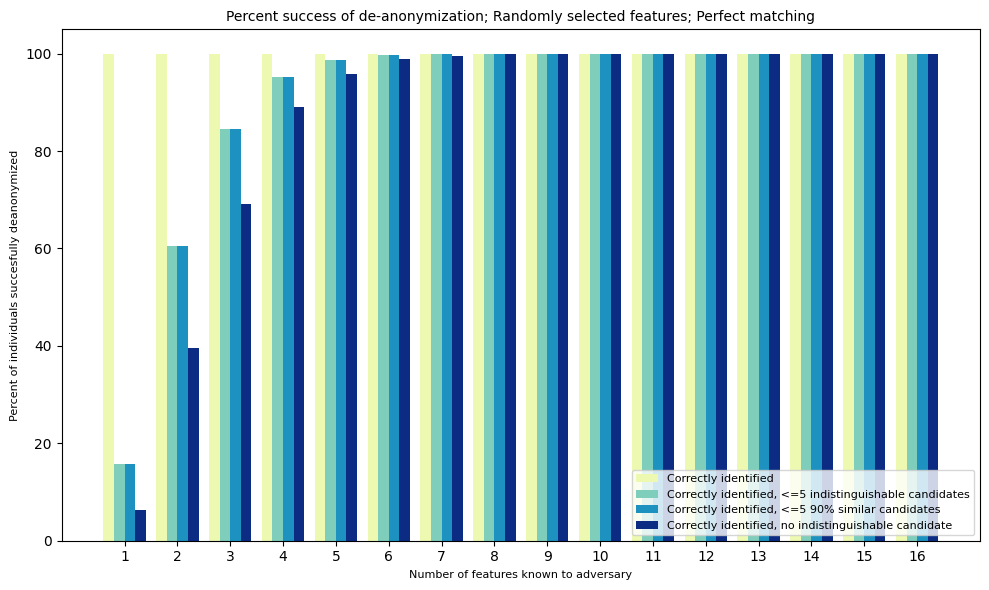

In [48]:
# Randomly selected, perfect information
r_random_perfect_regular, lv_random_perfect_regular = load_results("./results/r_random_perfect_regular")
plot_results(lv_random_perfect_regular, "Randomly selected features; Perfect matching")

100%|██████████| 16/16 [00:21<00:00,  1.37s/it]


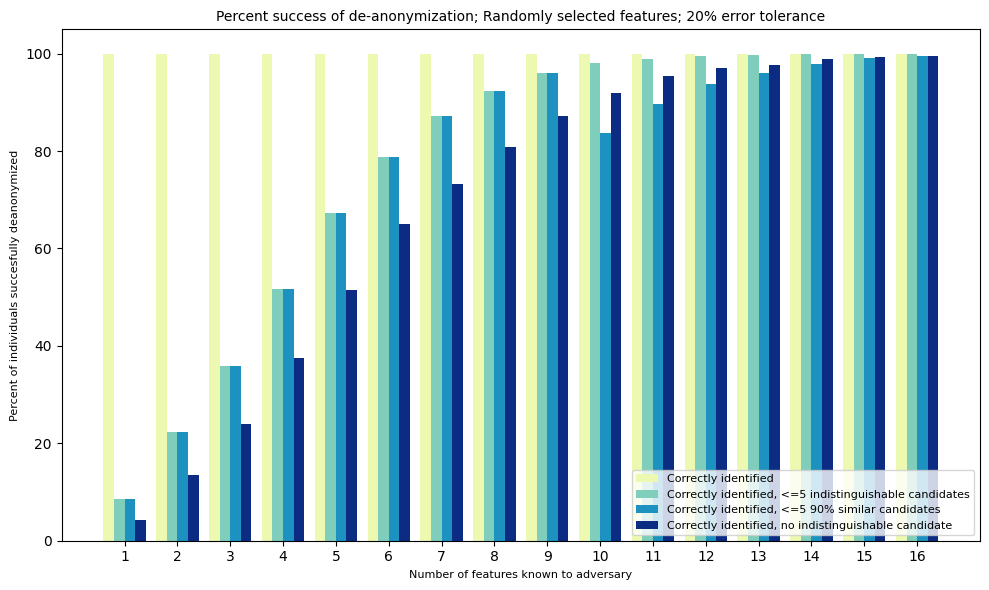

In [49]:
# Randomly selected, 20% error tolerance
r_random_twenty_regular, lv_random_twenty_regular = load_results("./results/r_random_twenty_regular")
plot_results(lv_random_twenty_regular, "Randomly selected features; 20% error tolerance")

100%|██████████| 16/16 [00:23<00:00,  1.47s/it]


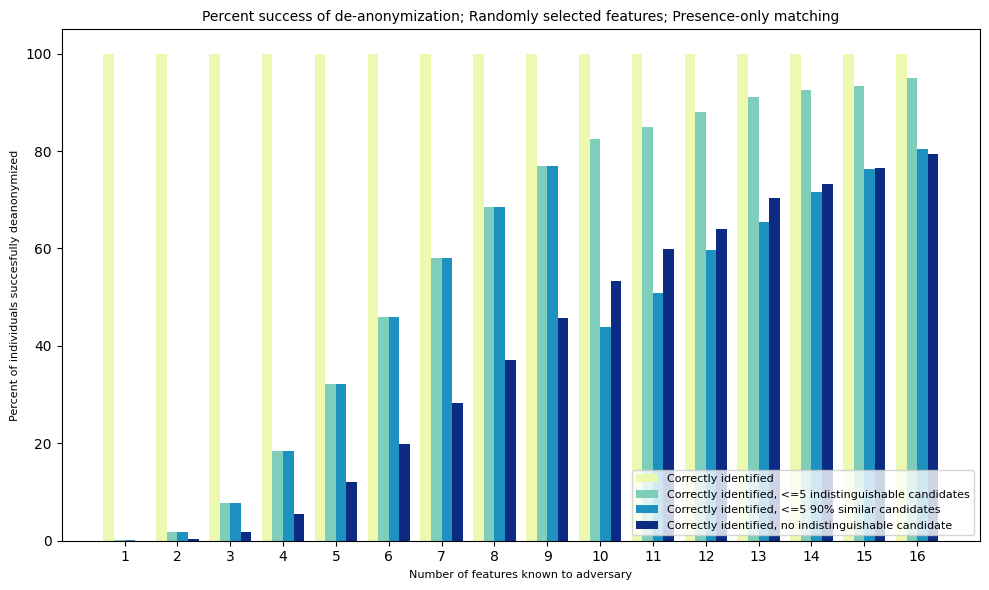

In [50]:
# Randomly selected, presence only
r_random_presence_regular, lv_random_presence_regular = load_results("./results/r_random_presence_regular")
plot_results(lv_random_presence_regular, "Randomly selected features; Presence-only matching")

100%|██████████| 16/16 [00:20<00:00,  1.29s/it]


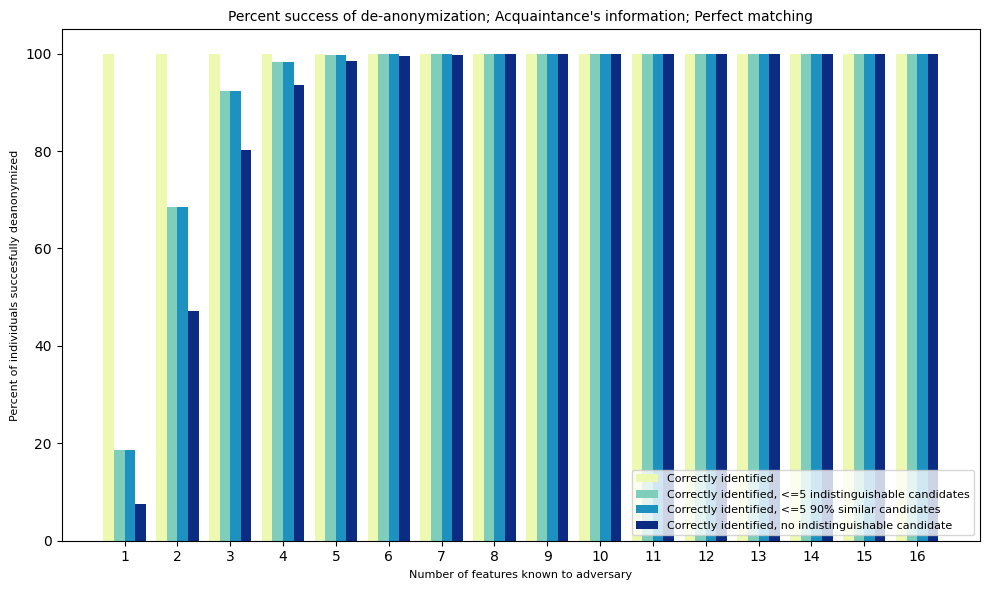

In [51]:
# Public 1, perfect information
r_public1_perfect_regular, lv_public1_perfect_regular = load_results("./results/r_public1_perfect_regular")
plot_results(lv_public1_perfect_regular, "Acquaintance\'s information; Perfect matching")

100%|██████████| 16/16 [00:21<00:00,  1.37s/it]


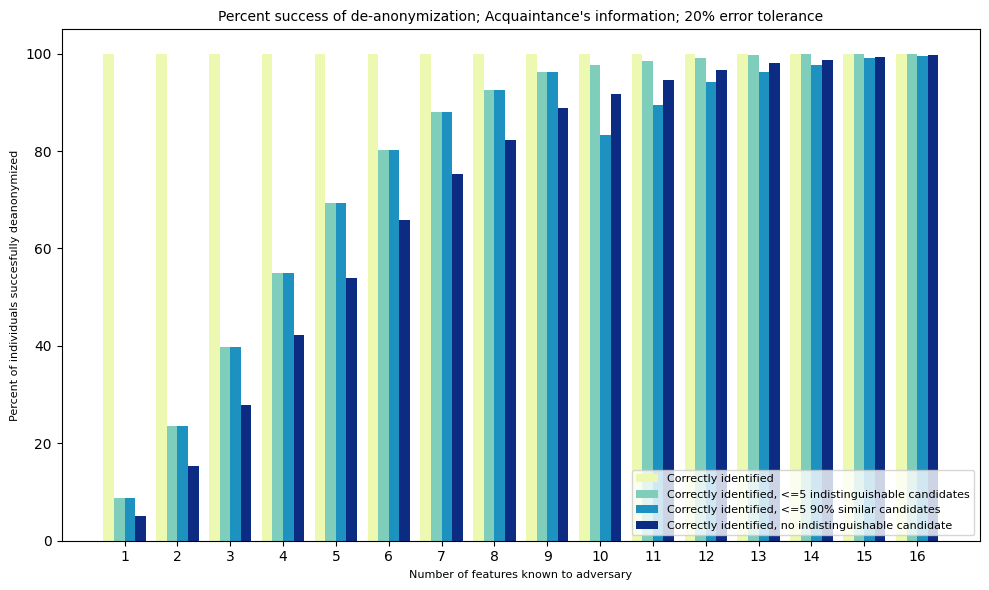

In [52]:
# Public 1, 20% error tolerance
r_public1_twenty_regular, lv_public1_twenty_regular = load_results("./results/r_public1_twenty_regular")
plot_results(lv_public1_twenty_regular, "Acquaintance\'s information; 20% error tolerance")

100%|██████████| 16/16 [00:21<00:00,  1.37s/it]


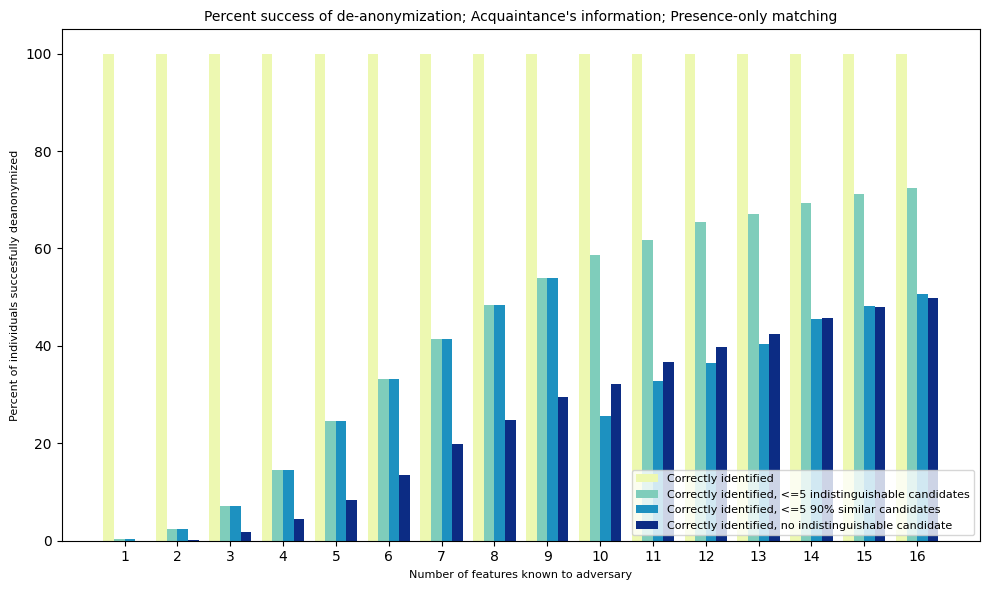

In [53]:
# Public 1, presence only
r_public1_presence_regular, lv_public1_presence_regular = load_results("./results/r_public1_presence_regular")
plot_results(lv_public1_presence_regular, "Acquaintance\'s information; Presence-only matching")

100%|██████████| 16/16 [00:20<00:00,  1.25s/it]


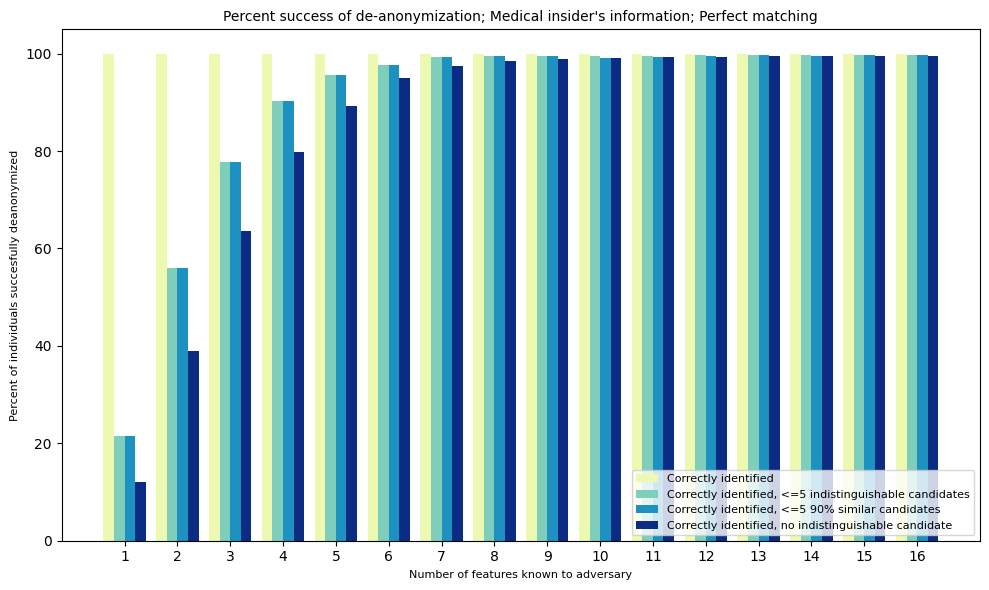

In [54]:
# Public 2, perfect information
r_public2_perfect_regular, lv_public2_perfect_regular = load_results("./results/r_public2_perfect_regular")
plot_results(lv_public2_perfect_regular, "Medical insider\'s information; Perfect matching")

100%|██████████| 16/16 [00:20<00:00,  1.27s/it]


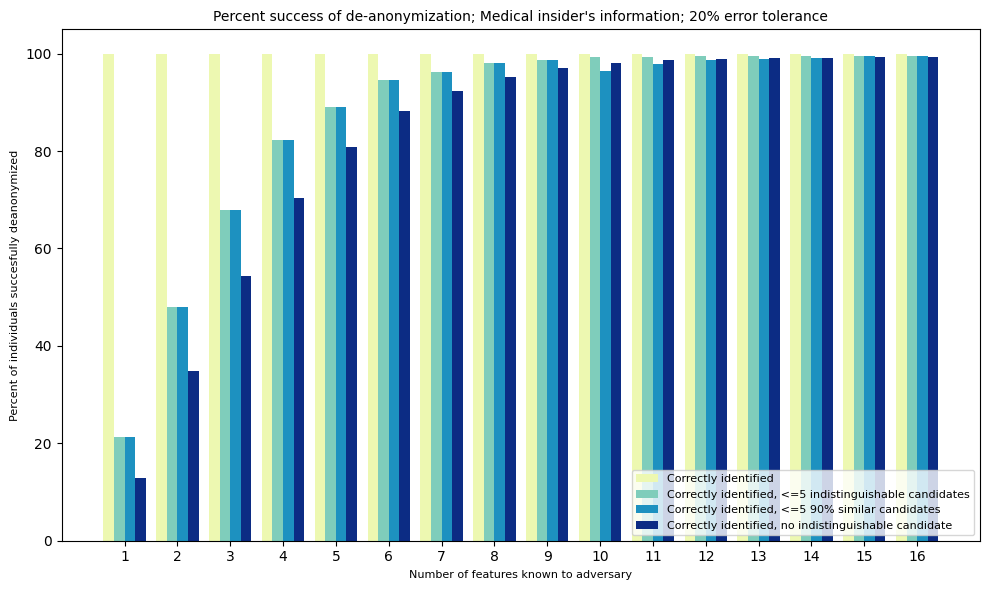

In [55]:
# Public 2, 20% error tolerance
r_public2_twenty_regular, lv_public2_twenty_regular = load_results("./results/r_public2_twenty_regular")
plot_results(lv_public2_twenty_regular, "Medical insider\'s information; 20% error tolerance")

100%|██████████| 16/16 [00:21<00:00,  1.35s/it]


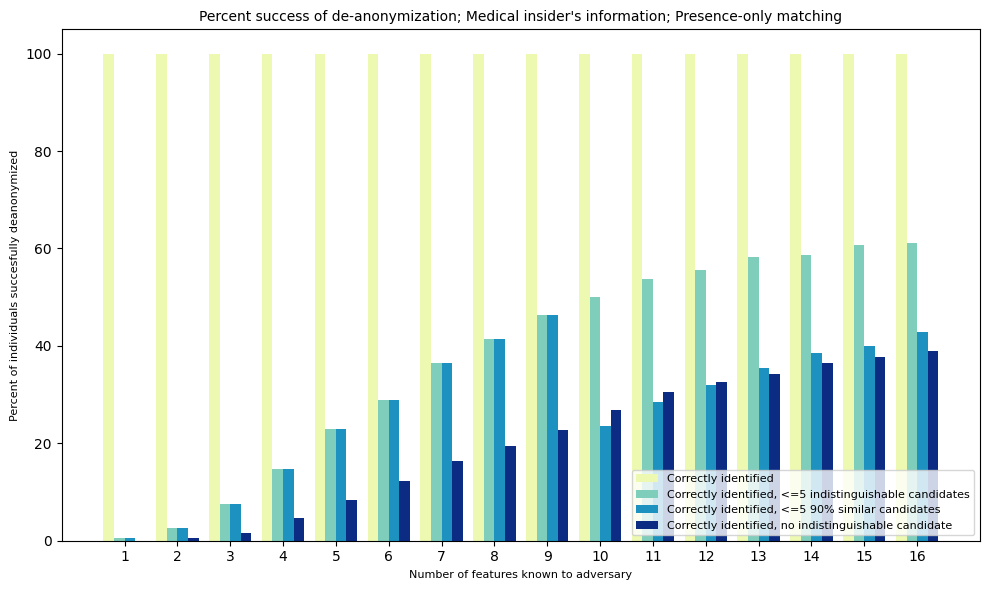

In [56]:
# Public 2, presence only
r_public2_presence_regular, lv_public2_presence_regular = load_results("./results/r_public2_presence_regular")
plot_results(lv_public2_presence_regular, "Medical insider\'s information; Presence-only matching")

100%|██████████| 16/16 [00:20<00:00,  1.31s/it]


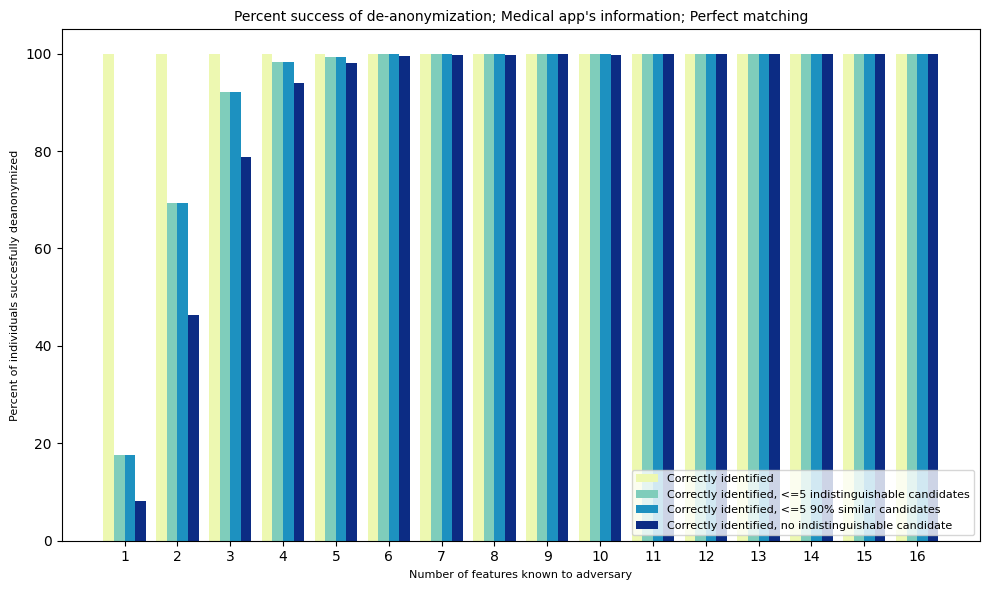

In [57]:
# Public 3, perfect information
r_public3_perfect_regular, lv_public3_perfect_regular = load_results("./results/r_public3_perfect_regular")
plot_results(lv_public3_perfect_regular, "Medical app\'s information; Perfect matching")

100%|██████████| 16/16 [00:34<00:00,  2.16s/it]


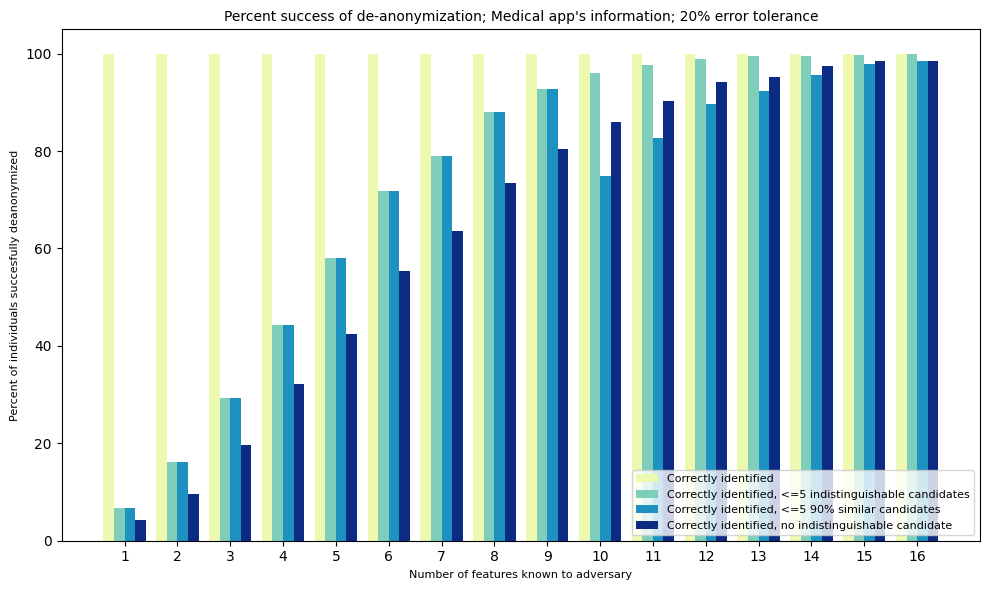

In [58]:
# Public 3, 20% error tolerance
r_public3_twenty_regular, lv_public3_twenty_regular = load_results("./results/r_public3_twenty_regular")
plot_results(lv_public3_twenty_regular, "Medical app\'s information; 20% error tolerance")

100%|██████████| 16/16 [00:30<00:00,  1.92s/it]


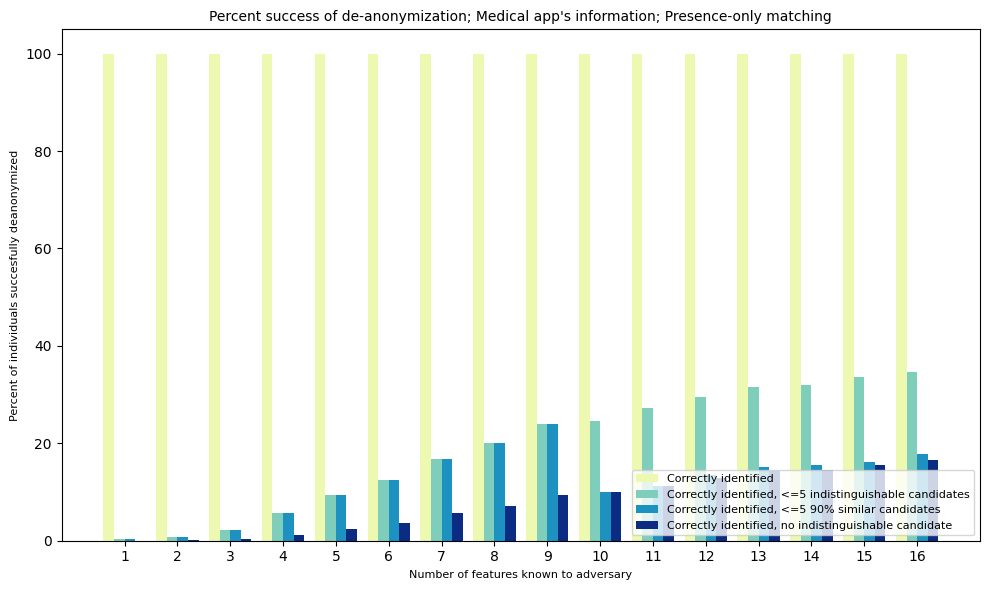

In [59]:
# Public 3, presence only
r_public3_presence_regular, lv_public3_presence_regular = load_results("./results/r_public3_presence_regular")
plot_results(lv_public3_presence_regular, "Medical app\'s information; Presence-only matching")

In [60]:
mostinfo_df = pd.DataFrame([lv_mostinfo_perfect_regular[3], lv_mostinfo_twenty_regular[3], lv_mostinfo_presence_regular[3]])
mostinfo_df.to_csv("./mostinfo_df.csv", index=False)
random_df = pd.DataFrame([lv_random_perfect_regular[3], lv_random_twenty_regular[3], lv_random_presence_regular[3]])
random_df.to_csv("./random_df.csv", index=False)
public1_df = pd.DataFrame([lv_public1_perfect_regular[3], lv_public1_twenty_regular[3], lv_public1_presence_regular[3]])
public1_df.to_csv("./public1_df.csv", index=False)
public2_df = pd.DataFrame([lv_public2_perfect_regular[3], lv_public2_twenty_regular[3], lv_public2_presence_regular[3]])
public2_df.to_csv("./public2_df.csv", index=False)
public3_df = pd.DataFrame([lv_public3_perfect_regular[3], lv_public3_twenty_regular[3], lv_public3_presence_regular[3]])
public3_df.to_csv("./public3_df.csv", index=False)

In [61]:
mostinfo_df = pd.read_csv("./mostinfo_df.csv")
random_df = pd.read_csv("./random_df.csv")
public1_df = pd.read_csv("./public1_df.csv")
public2_df = pd.read_csv("./public2_df.csv")
public3_df = pd.read_csv("./public3_df.csv")

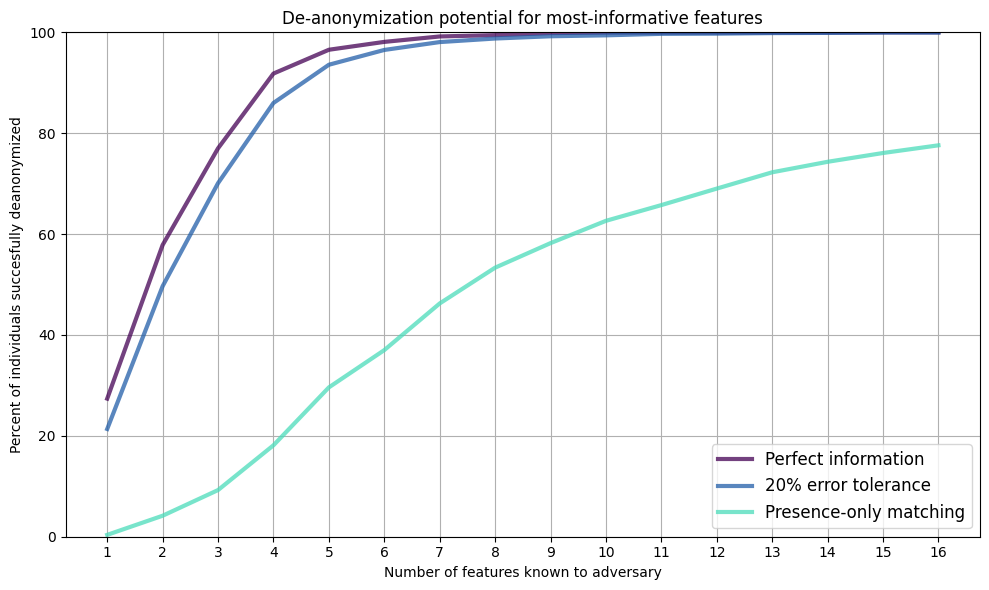

In [62]:
fig, ax = plt.subplots(figsize=(10, 6))
line1 = ax.plot(mostinfo_df.iloc[0, 1:], label='Perfect information', color='#440154', linewidth=3, alpha=0.75)
line2 = ax.plot(mostinfo_df.iloc[1, 1:], label='20% error tolerance', color='#225ea8', linewidth=3, alpha=0.75)
line3 = ax.plot(mostinfo_df.iloc[2, 1:], label='Presence-only matching', color='#4bdcba', linewidth=3, alpha=0.75)

ax.set_xlabel('Number of features known to adversary', fontsize=10)
ax.set_ylabel('Percent of individuals succesfully deanonymized', fontsize=10)
ax.set_title('De-anonymization potential for most-informative features', fontsize=12)
ax.legend(fontsize=12, loc="lower right")
ax.set_ylim(0, 100)

plt.grid(True)
plt.tight_layout()
plt.show()

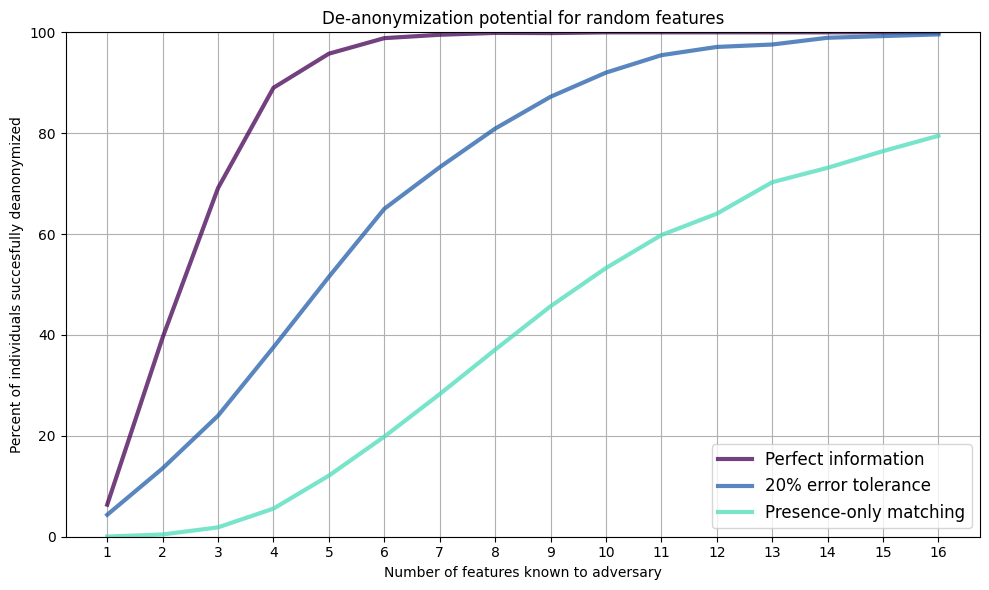

In [63]:
fig, ax = plt.subplots(figsize=(10, 6))
line1 = ax.plot(random_df.iloc[0, 1:], label='Perfect information', color='#440154', linewidth=3, alpha=0.75)
line2 = ax.plot(random_df.iloc[1, 1:], label='20% error tolerance', color='#225ea8', linewidth=3, alpha=0.75)
line3 = ax.plot(random_df.iloc[2, 1:], label='Presence-only matching', color='#4bdcba', linewidth=3, alpha=0.75)
# line3 = ax.plot(manip8[1][1:], label='20% error tolerance (robust)', color='#4bdcba', linestyle="dashed", linewidth=3, alpha=0.75)

ax.set_xlabel('Number of features known to adversary', fontsize=10)
ax.set_ylabel('Percent of individuals succesfully deanonymized', fontsize=10)
ax.set_title('De-anonymization potential for random features', fontsize=12)
ax.legend(fontsize=12, loc="lower right")
ax.set_ylim(0, 100)

plt.grid(True)
plt.tight_layout()
plt.show()

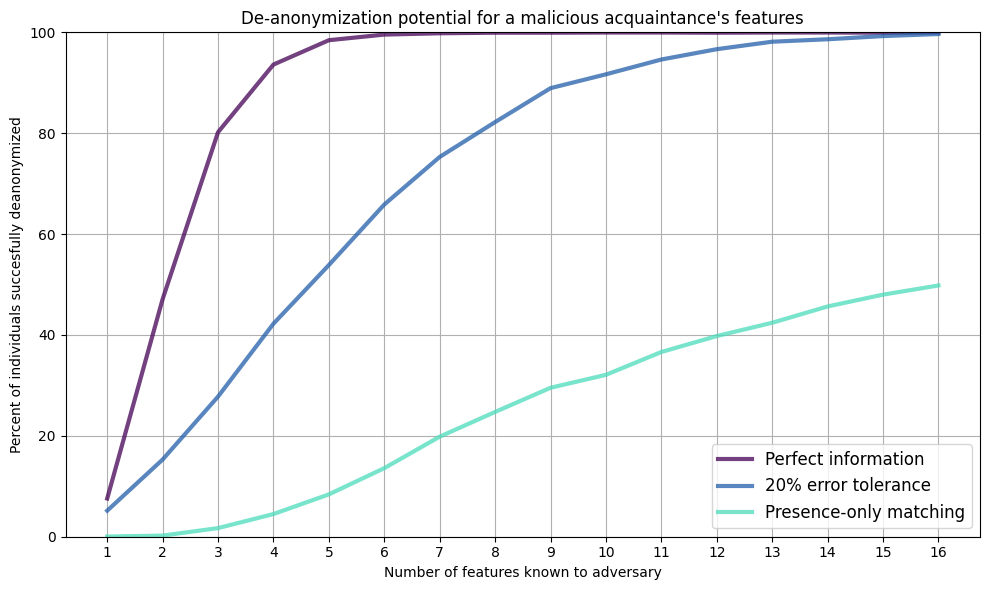

In [64]:
fig, ax = plt.subplots(figsize=(10, 6))
line1 = ax.plot(public1_df.iloc[0, 1:], label='Perfect information', color='#440154', linewidth=3, alpha=0.75)
line2 = ax.plot(public1_df.iloc[1, 1:], label='20% error tolerance', color='#225ea8', linewidth=3, alpha=0.75)
line3 = ax.plot(public1_df.iloc[2, 1:], label='Presence-only matching', color='#4bdcba', linewidth=3, alpha=0.75)
# line3 = ax.plot(manip8[1][1:], label='20% error tolerance (robust)', color='#4bdcba', linestyle="dashed", linewidth=3, alpha=0.75)

ax.set_xlabel('Number of features known to adversary', fontsize=10)
ax.set_ylabel('Percent of individuals succesfully deanonymized', fontsize=10)
ax.set_title('De-anonymization potential for a malicious acquaintance\'s features', fontsize=12)
ax.legend(fontsize=12, loc="lower right")
ax.set_ylim(0, 100)

plt.grid(True)
plt.tight_layout()
plt.show()

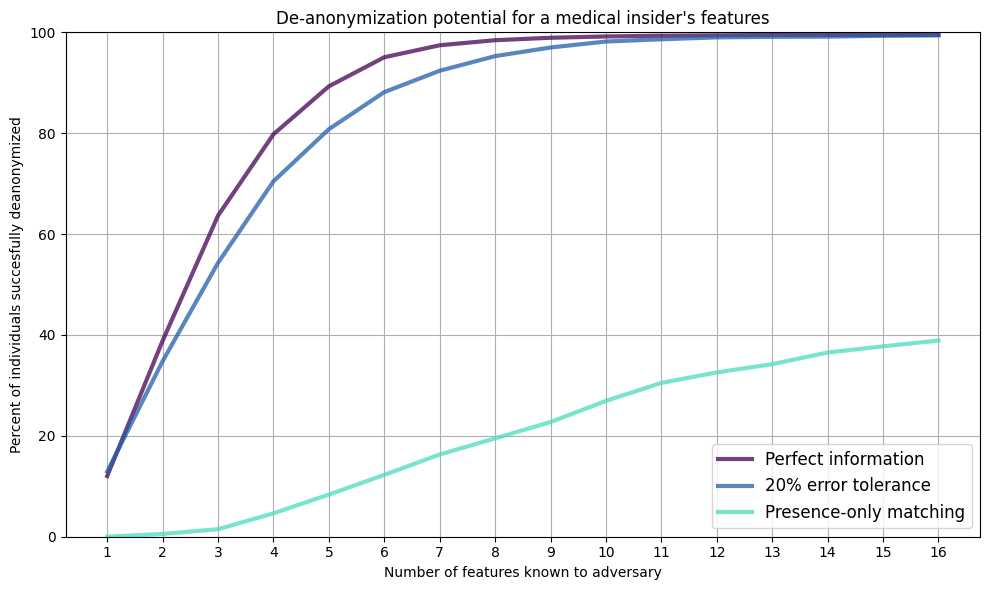

In [65]:
fig, ax = plt.subplots(figsize=(10, 6))
line1 = ax.plot(public2_df.iloc[0, 1:], label='Perfect information', color='#440154', linewidth=3, alpha=0.75)
line2 = ax.plot(public2_df.iloc[1, 1:], label='20% error tolerance', color='#225ea8', linewidth=3, alpha=0.75)
line3 = ax.plot(public2_df.iloc[2, 1:], label='Presence-only matching', color='#4bdcba', linewidth=3, alpha=0.75)
# line3 = ax.plot(manip8[1][1:], label='20% error tolerance (robust)', color='#4bdcba', linestyle="dashed", linewidth=3, alpha=0.75)

ax.set_xlabel('Number of features known to adversary', fontsize=10)
ax.set_ylabel('Percent of individuals succesfully deanonymized', fontsize=10)
ax.set_title('De-anonymization potential for a medical insider\'s features', fontsize=12)
ax.legend(fontsize=12, loc="lower right")
ax.set_ylim(0, 100)

plt.grid(True)
plt.tight_layout()
plt.show()

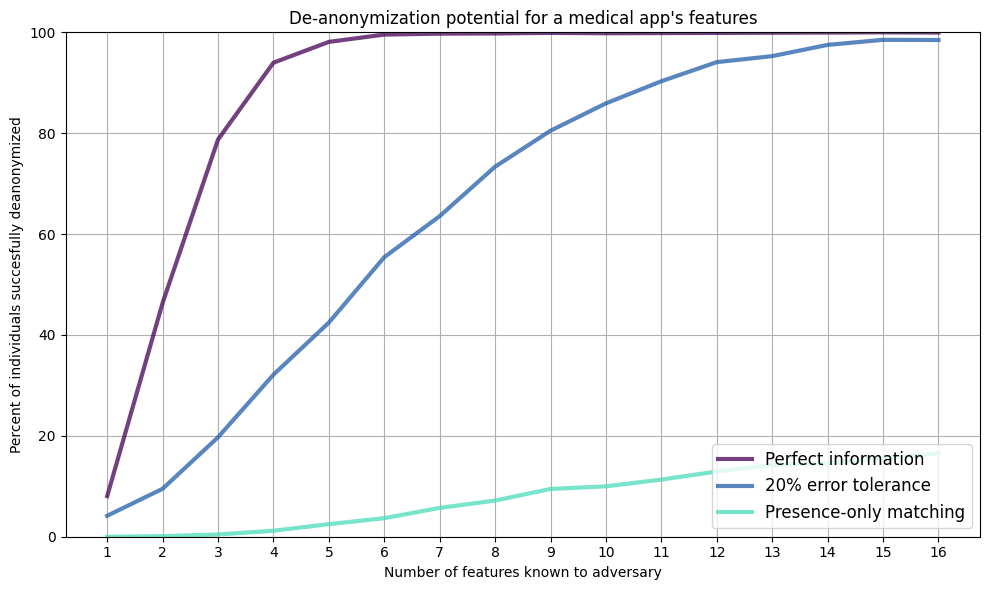

In [66]:
fig, ax = plt.subplots(figsize=(10, 6))
line1 = ax.plot(public3_df.iloc[0, 1:], label='Perfect information', color='#440154', linewidth=3, alpha=0.75)
line2 = ax.plot(public3_df.iloc[1, 1:], label='20% error tolerance', color='#225ea8', linewidth=3, alpha=0.75)
line3 = ax.plot(public3_df.iloc[2, 1:], label='Presence-only matching', color='#4bdcba', linewidth=3, alpha=0.75)
# line3 = ax.plot(manip8[1][1:], label='20% error tolerance (robust)', color='#4bdcba', linestyle="dashed", linewidth=3, alpha=0.75)

ax.set_xlabel('Number of features known to adversary', fontsize=10)
ax.set_ylabel('Percent of individuals succesfully deanonymized', fontsize=10)
ax.set_title('De-anonymization potential for a medical app\'s features', fontsize=12)
ax.legend(fontsize=12, loc="lower right")
ax.set_ylim(0, 100)

plt.grid(True)
plt.tight_layout()
plt.show()

In [115]:
# Best guess as defined by the paper
def best_guess(df, candidates, eccentricity):
    sorted_candidates = candidates.sort_values(ascending=False)
    heuristic = (sorted_candidates.index[0] - sorted_candidates.index[1])/df.std()
    return sorted_candidates.index[0] if heuristic >= eccentricity else -1

In [141]:
# Matching criterion as defined by the paper
def match_results(df, col, alpha):
    
    candidates = df.iloc[:, col]
    candidates = candidates[candidates >= alpha]
    if candidates.empty:
        return 0
    return len(candidates)

In [142]:
# Robust matching criterion as defined by the paper
def match_results_robust(df, col, alpha):
    
    new_df = df.iloc[:, col]
    candidates = new_df[new_df >= alpha]
    if candidates.empty:
        return 0
    elif candidates.shape[0] > 1:
        return best_guess(new_df, candidates, 1.5)
    else:
        return candidates.index[0]

In [ ]:
supports = df3[1].progress_apply(lambda col: col.index.to_series().apply(lambda row_idx: union_support_count(df3, row_idx, col.name)))
# supports.to_csv("./results/supports.csv")
# supports = pd.read_csv(f"./results/supports.csv", index_col=0)
supports

<Axes: >

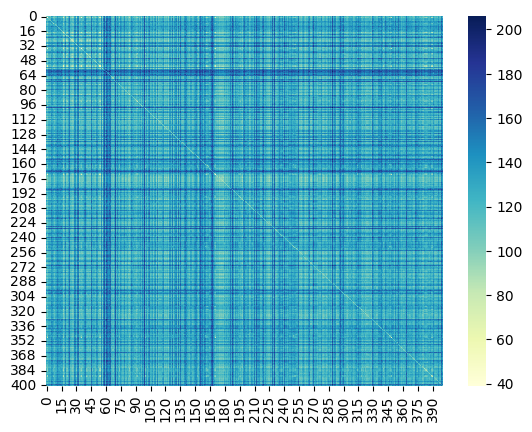

In [153]:
sns.heatmap(supports.iloc[:2000, :2000].astype(float), annot=False, cmap="YlGnBu", linewidths=0) # count=100